## <center>Name Generator using Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) </center>

Input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”

Steps involved are:
<br>
1)Preparing the Data
<br>
2)Creating the Network
<br>
3)Training of the Network
<br>
4)Sampling the Network

Dependencies
<br>
1)PyTorch
<br>
2)glob
<br>
3)unicodedata
<br>
4)string
<br>
5)random
<br>
6)time
<br>
7)math
<br>
8)matplotlib

Language
<br>
1)Python (3.6)

### 1) Preparing the Data

Extracted few tupples from the dataset and splitted into various text document (category).

Link for dataset
https://github.com/hadley/data-baby-names/blob/master/baby-names.csv

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

#Convert Unicode to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

#Printing a test Unicode to ASCII
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']
O'Neal


### 2) Creating the network

Imported PyTorch

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

### 3) Training of the network

In [3]:
import random

#Random selection from list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

#Select a random category and random line
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
#One-Hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

#One-hot matrix of first to last letters for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

#LongTensor of second letter to end for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [5]:
#Make category, input, and target from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

In [7]:
#To check time duration required to train the model timestamp is added
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 3.3635
0m 31s (10000 10%) 2.2743
0m 47s (15000 15%) 2.3569
1m 2s (20000 20%) 2.7965
1m 18s (25000 25%) 3.4670
1m 33s (30000 30%) 2.7449
1m 49s (35000 35%) 2.7090
2m 4s (40000 40%) 3.1420
2m 20s (45000 45%) 2.8536
2m 35s (50000 50%) 2.4761
2m 52s (55000 55%) 2.1374
3m 7s (60000 60%) 2.0293
3m 23s (65000 65%) 2.8040
3m 38s (70000 70%) 2.0339
3m 54s (75000 75%) 2.2124
4m 9s (80000 80%) 2.4027
4m 25s (85000 85%) 1.8943
4m 41s (90000 90%) 2.0207
4m 57s (95000 95%) 1.7656
5m 12s (100000 100%) 2.1502


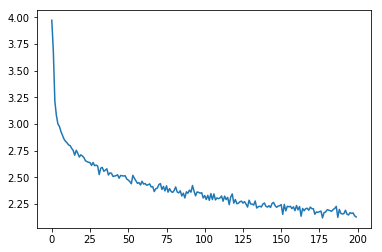

In [10]:
#Plotting the Losses
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [11]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('1', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('2', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('3', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('4', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('5', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('6', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('7', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

samples('8', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

Allan
Bertin
Clert
Danie
Ellin
Fren
Garlin
Harlie
Iriel
Jose
Kellie
Len
Marlin
Nallie
Oric
Perlin
Qarlis
Roley
Sillie
Tollie
Uarlin
Varthe
Willie
Xander
Yarle
Zalland
Aler
Berlie
Clard
Danie
Elin
Frence
Gere
Hertin
Irich
Jone
Kert
Leriel
Marthel
Nellie
Orich
Perlin
Qerthe
Roley
Sillay
Tollies
Uarlin
Vernie
Willand
Xerlie
Yerthar
Zert
Allish
Bertin
Cland
Donnie
Ellis
Frand
Garlin
Harlin
Iley
Jonnies
Kert
Len
Millia
Nallis
Oley
Perlin
Qarley
Ronel
Salle
Tollis
Uallandone
Verthe
Willie
Xarlie
Yarlin
Zand
Allie
Berthe
Cland
Danie
Elie
Fertin
Gariell
Hallien
Irich
Jonel
Kert
Leniel
Marley
Narlina
Orie
Parlie
Qarlie
Roley
Sillie
Tone
Uarlin
Vertin
Willie
Xarlin
Yerthe
Zerlin
Aler
Benton
Clard
Done
Elie
Frencill
Gerton
Harlin
Irice
Jeste
Kert
Lonay
Marthe
Narley
Orich
Parlie
Qarline
Roley
Sarley
Tonisha
Uarline
Vert
Willie
Xerlin
Yarlie
Zarline
Allis
Bertie
Carlin
Danie
Ellie
Frence
Gallie
Hardil
Irich
Jone
Kert
Len
Marlin
Ney
Orich
Parlie
Qarley
Roley
Sallie
Tollan
Uarlin
Vertie
Willie
Xarli